<a href="https://colab.research.google.com/github/erankfmn/anomaly_detection/blob/main/gasPrice%3B_OCSVM%2BiForest_%2B_Group_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import

In [ ]:
#load_ext nb_black
from IPython.core.debugger import set_trace
import os
import sys
import collections, numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from numpy import array
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
from IPython.display import display, clear_output
from numpy import mean, sqrt, square, arange
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from pandas import read_csv
import matplotlib.dates as md
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('darkgrid')
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
plt.style.use(style="seaborn")
from datetime import datetime
from datetime import timedelta
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
dataset = pd.read_json('/content/gdrive/MyDrive/dataset1.txt')

df=dataset.loc[dataset['isError']==0]
value=array(df['value'])
time=array(df['timeStamp'])

j=0
i=0

while i<len(time) and j<len(time):
  j=i+1
  while time[i:i+1]==time[j:j+1]:
    value[i]=value[i]+value[j]
    value[j]=None
    j=j+1
  i=j


df['value']=value
cdf=df.loc[df['value']>=0]
#df=cdf
df={'index':cdf.index,'DnT':cdf['timeStamp'],'value':cdf['gasPrice'],'gas':cdf['gas'],'gasPrice':cdf['gasPrice']}
df=pd.DataFrame(df)
df.to_csv('/content/gdrive/MyDrive/newDataRun/newDataForGroupC.csv')

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
#df=pd.read_csv('/content/gdrive/MyDrive/newDatavec.csv')
df = pd.read_csv('/content/gdrive/MyDrive/newDataRun/newDataForGroupC.csv')
value=array(df['value'])
time=array(df['DnT'])

Mounted at /content/gdrive


## OCSVM

In [ ]:
value=array(df['value'])
time=array(df['DnT'])

############For User ########################
#define database
day=4
minutes=5 #check every 5 min
hour=24 #defined as 24 while day is >1, else equal to 1;

#define set
start_date='2017-08-04 00:00:00'
end_date = '2017-08-07 23:59:59'
date_format_str = '%Y-%m-%d %H:%M:%S'
totalDays=13

##############For Developer #################
#do not change
vector_size=60*minutes
flag=0
vectorsPerHour=int(60/minutes)
newStartTimeDelta=1
newEndTimeDelta_min=minutes-1
newEndTimeDelta_sec=59
allDates=np.split((pd.date_range(start='2017-08-04 00:00:00', end = '2017-08-16 23:59:59', freq ='1S')),3744)
allValues=np.zeros((vectorsPerHour*hour*totalDays,vector_size))
ifano=np.zeros(vectorsPerHour*hour*totalDays)


c=0 ## index of vectors from all valuse including zeros
m=0 ##index of values from the data set
flag=0 ## indicator of values from the data set
NewEndTime=start_date

#####################DATA BASE
while(c<len(ifano)):
  #########creat new database
  #Dates
  DataBase_values=np.zeros((12*hour*day,vector_size))
  FourDaysDateRange = pd.date_range(start=start_date, end = end_date, freq ='1S')
  DataBase_dates=np.split(FourDaysDateRange,1152) # (vec,1152 equal part,len -5 min)
  #insert all values to the correct index compared to the DataBase_dates
  #for i in range (len(df)):

  if m==0:
    nextIndex=m
  else:
    m=nextIndex
    
  tempValue=value[nextIndex]
  for j in range (12*hour*day):
    for k in range (vector_size):
      if str(DataBase_dates[j][k])==time[nextIndex]:
        DataBase_values[j][k]=tempValue
        m=m+1
        nextIndex=nextIndex+1
        tempValue=value[nextIndex]               

  print('finish database in index:' + str(m))
  print(collections.Counter(ifano))
  
  if c==0:
    allValues[:1152]=DataBase_values
    print(allValues.max())
    c=12*hour*day
    
  ##next database
  given_time = datetime.strptime(start_date,date_format_str)
  NewStartDateDatabase = given_time + timedelta(days=4)
  NewEndDateDatabase = NewStartDateDatabase + timedelta(days=3,hours=23, minutes=59,seconds=59)
  
  moran=0
  ########### Remove anomalies from database
  for i in range(c-12*hour*day,c):
    f=0
    if ifano[i]==-1:
      DataBase_values[f]=np.zeros(len(checked_vector_value))
      moran=moran+1
    f=f+1
  print('red vectors: '+ str(moran))
  #####################CHECK VECTOR
  time_str = end_date
  # Given timestamp in string

  while(c<len(ifano)):    # Given timestamp in string
    if  c>0 and str(NewEndDateDatabase)==str(NewEndTime):
      end_date=str(NewEndDateDatabase)
      start_date=str(NewStartDateDatabase)
      print('Database Updated')
      break

    else:
      date_format_str = '%Y-%m-%d %H:%M:%S'
      # create datetime object from timestamp string
      given_time = datetime.strptime(time_str, date_format_str)
    
      # Add 5 minutes to datetime object
      NewStartTime = given_time + timedelta(seconds=1)
      NewEndTime = NewStartTime + timedelta(minutes=4,seconds=59)
      #days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0

      checked_vector_time = pd.date_range(start=str(NewStartTime) ,end = str(NewEndTime), freq ='1S')
      checked_vector_time = np.split(checked_vector_time,1)
      checked_vector_value=np.zeros((len(DataBase_values[1])))
        
      tempValue=value[m]

      ##creating new vector
      for k in range (300):
        if time[m]==str(end_date) or m==len(df)-1:
           break 

        if time[m]==str(checked_vector_time[0][k]):
          checked_vector_value[k]=tempValue
          m=m+1
          tempValue=value[m]
          flag=1

      to_check=np.concatenate((DataBase_values, [checked_vector_value]),axis=0)
      allValues[c]=checked_vector_value
        #####################Algorithem
        
      if flag==1:
        #print(NewStartTime)
      

        clf=OneClassSVM(nu=0.00005, kernel="rbf", gamma='scale',tol=0.0001)
        clf.fit(to_check)
        pred = clf.predict(to_check)
       
       
        if pred[len(to_check)-1] == -1:
          #print('is anomaly!!!!!!!!!!!!!!')
          ifano[c]=-1
        else:
          ifano[c]=1
        
        #print(collections.Counter(ifano))
      else:
         ifano[c]=1
       
      flag=0


    c=c+1
    
    time_str=str(NewEndTime)

finish database in index:105
Counter({0.0: 3744})
61500000000.0
red vectors: 0
Database Updated
finish database in index:568
Counter({0.0: 2592, 1.0: 980, -1.0: 172})
red vectors: 172
Database Updated
finish database in index:2043
Counter({1.0: 1963, 0.0: 1440, -1.0: 341})
red vectors: 169


In [ ]:
print(collections.Counter(ifano))

Counter({1.0: 2223, 0.0: 1152, -1.0: 369})


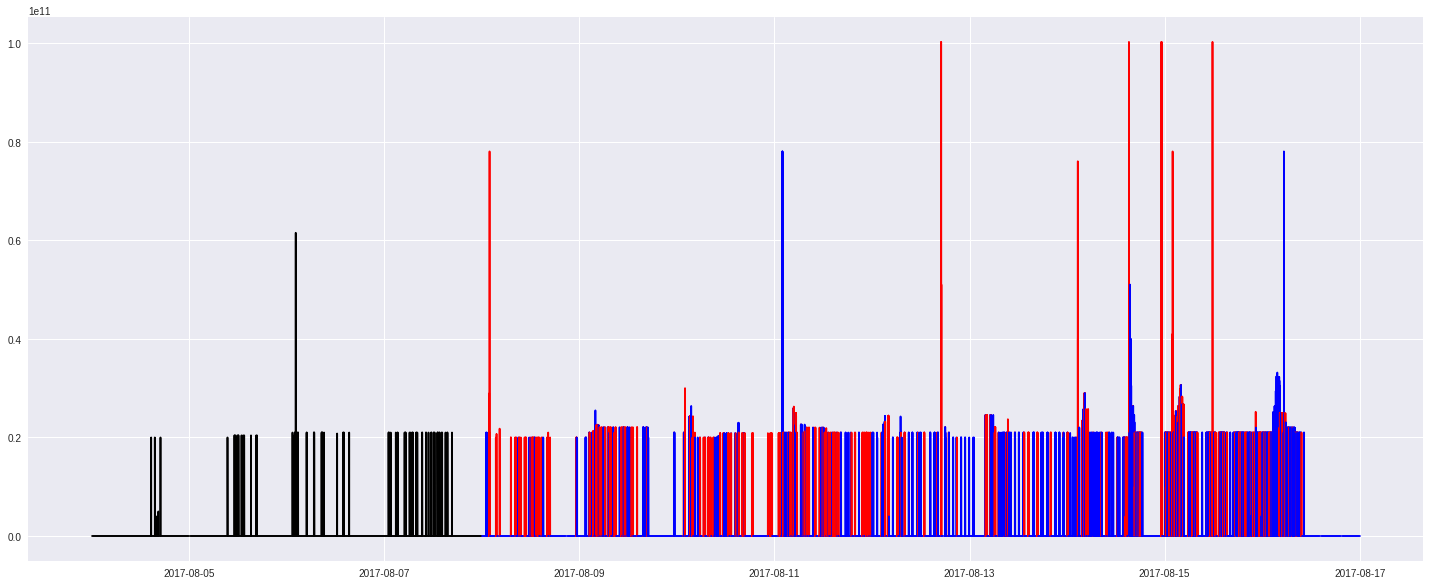

In [ ]:
    # plot results
    plt.figure(figsize=(25,10))  

    for i in range(0,3744):
        if ifano[i]==-1:            
            color='red'
        if ifano[i]==1:
            color='blue'
        if ifano[i]==0:
          color='black'

        plt.plot(allDates[i],allValues[i], color=color)
        
    plt.show()
    clear_output(wait = True) 

In [ ]:
ocsvm_ifano=ifano

## iForest

In [ ]:
#from sklearn.ensemble import IsolationForest
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)
#df=pd.read_csv('/content/gdrive/MyDrive/newDatavec.csv')
#value=array(df['value'])
#time=array(df['DnT'])

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/newDataRun/newDataForGroupC.csv')


In [ ]:
value=array(df['value'])
time=array(df['DnT'])

############For User ########################
#define database
day=4
minutes=5 #check every 5 min
hour=24 #defined as 24 while day is >1, else equal to 1;

#define set
start_date='2017-08-04 00:00:00'
end_date = '2017-08-07 23:59:59'
date_format_str = '%Y-%m-%d %H:%M:%S'
totalDays=13

##############For Developer #################
#do not change
vector_size=60*minutes
flag=0
vectorsPerHour=int(60/minutes)
newStartTimeDelta=1
newEndTimeDelta_min=minutes-1
newEndTimeDelta_sec=59
allDates=np.split((pd.date_range(start='2017-08-04 00:00:00', end = '2017-08-16 23:59:59', freq ='1S')),3744)
allValues=np.zeros((vectorsPerHour*hour*totalDays,vector_size))
ifano=np.zeros(vectorsPerHour*hour*totalDays)

c=0 ## index of vectors from all valuse including zeros
m=0 ##index of values from the data set
flag=0 ## indicator of values from the data set
NewEndTime=start_date

#####################DATA BASE
while(c<len(ifano)):
  #########creat new database
  #Dates
  DataBase_values=np.zeros((12*hour*day,vector_size))
  FourDaysDateRange = pd.date_range(start=start_date, end = end_date, freq ='1S')
  DataBase_dates=np.split(FourDaysDateRange,1152) # (vec,1152 equal part,len -5 min)
  #insert all values to the correct index compared to the DataBase_dates
  #for i in range (len(df)):

  if m==0:
    nextIndex=m
  else:
    m=nextIndex
    
  tempValue=value[nextIndex]
  for j in range (12*hour*day):
      for k in range (vector_size):
          if str(DataBase_dates[j][k])==time[nextIndex]:
              DataBase_values[j][k]=tempValue
              m=m+1
              nextIndex=nextIndex+1
              tempValue=value[nextIndex]               
  
  print('finish database in index:' + str(m))
  print(collections.Counter(ifano))
  
  if c==0:
    allValues[:1152]=DataBase_values
    print(allValues.max())
    c=12*hour*day
    
  ##next database
  given_time = datetime.strptime(start_date,date_format_str)
  NewStartDateDatabase = given_time + timedelta(days=4)
  NewEndDateDatabase = NewStartDateDatabase + timedelta(days=3,hours=23, minutes=59,seconds=59)
  

  ########### Remove anomalies
  for i in range(c-12*hour*day,c):
    f=0
    if ifano[i]==-1:
      DataBase_values[f]=np.zeros(len(checked_vector_value))
    f=f+1

  #####################CHECK VECTOR
  time_str = end_date
  # Given timestamp in string

  while(c<len(ifano)):    # Given timestamp in string
    if  c>0 and str(NewEndDateDatabase)==str(NewEndTime):
      end_date=str(NewEndDateDatabase)
      start_date=str(NewStartDateDatabase)
      print('Database Updated')
      break

    else:
      date_format_str = '%Y-%m-%d %H:%M:%S'
      # create datetime object from timestamp string
      given_time = datetime.strptime(time_str, date_format_str)
    
      # Add 5 minutes to datetime object
      NewStartTime = given_time + timedelta(seconds=1)
      NewEndTime = NewStartTime + timedelta(minutes=4,seconds=59)
      #days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0

      checked_vector_time = pd.date_range(start=str(NewStartTime) ,end = str(NewEndTime), freq ='1S')
      checked_vector_time = np.split(checked_vector_time,1)
      checked_vector_value=np.zeros((len(DataBase_values[1])))
        
      tempValue=value[m]

      ##creating new vector
      for k in range (300):
        if time[m]==str(end_date) or m==len(df)-1:
           break 

        if time[m]==str(checked_vector_time[0][k]):
          checked_vector_value[k]=tempValue
          m=m+1
          tempValue=value[m]
          flag=1

      to_check=np.concatenate((DataBase_values, [checked_vector_value]),axis=0)
      allValues[c]=checked_vector_value
        #####################Algorithem
        
      if flag==1:
        #print(NewStartTime)
      

        clf=IsolationForest(n_estimators=50, max_samples='auto', n_jobs=-1, random_state = np.random.RandomState(42),contamination=0.005,warm_start=False)
        clf.fit(to_check)
        pred = clf.predict(to_check)
       
       
        if pred[len(to_check)-1] == -1:
          #print('is anomaly!!!!!!!!!!!!!!')
          ifano[c]=-1
        else:
          ifano[c]=1
        #print(collections.Counter(ifano))
      else:
         ifano[c]=1
      
      flag=0


    c=c+1
    
    time_str=str(NewEndTime)

finish database in index:105
Counter({0.0: 3744})
61500000000.0
Database Updated
finish database in index:568
Counter({0.0: 2592, 1.0: 1066, -1.0: 86})
Database Updated
finish database in index:2043
Counter({1.0: 2164, 0.0: 1440, -1.0: 140})


In [ ]:
print(collections.Counter(ifano))

Counter({1.0: 2452, 0.0: 1152, -1.0: 140})


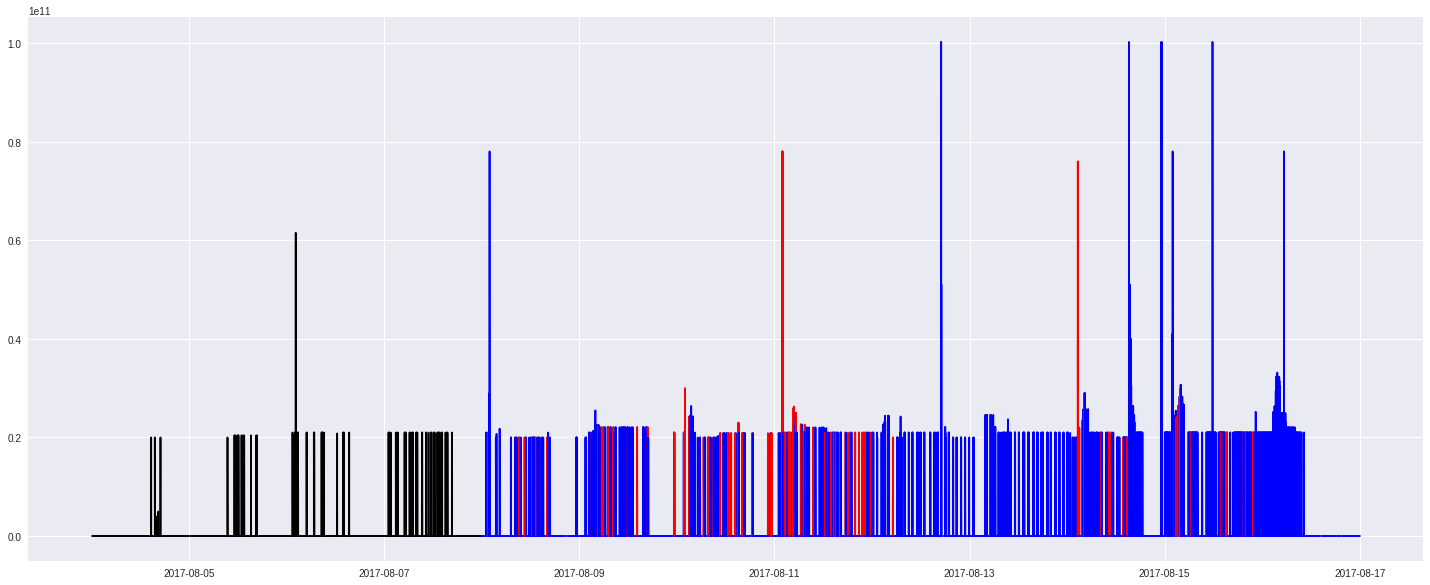

In [ ]:
# plot results
plt.figure(figsize=(25,10))  

for i in range(0,3744):
    if ifano[i]==-1:            
        color='red'
    if ifano[i]==1:
        color='blue'
    if ifano[i]==0:
      color='black'

    plt.plot(allDates[i],allValues[i], color=color)
    
plt.show()
clear_output(wait = True) 

In [ ]:
iforest_ifano=ifano

## Group C

In [ ]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode()
import numpy as np
import matplotlib.ticker
from numpy import array
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline
#import chart_studio.plotly as py
#!pip install plotly==5.3.1
#import plotly.graph_objects as go
#from _plotly_future_ import v4_subplots

In [ ]:
allValues1=allValues.flatten()
allDates1=numpy.array(allDates).flatten()
arr_allData={'DnT': allDates1, 'values':allValues1}
df_allData=pd.DataFrame(arr_allData)

In [ ]:
df_allValues=pd.DataFrame(allValues)
df_allDates=pd.DataFrame(allDates)

In [ ]:
anomalyOCSVMvalues = df_allValues.loc[ocsvm_ifano == -1].to_numpy().flatten()
anomalyOCSVMdates = df_allDates.loc[ocsvm_ifano == -1].to_numpy().flatten()
arr_anomaly_ocsvm={'DnT': anomalyOCSVMdates, 'values':anomalyOCSVMvalues}
df_anomaly_ocsvm=pd.DataFrame(arr_anomaly_ocsvm)
df_anomaly_ocsvm

,DnT,values
0,2017-08-08 01:45:00,0.0
1,2017-08-08 01:45:01,0.0
2,2017-08-08 01:45:02,0.0
3,2017-08-08 01:45:03,0.0
4,2017-08-08 01:45:04,0.0
...,...,...
110695,2017-08-16 09:39:55,0.0
110696,2017-08-16 09:39:56,0.0
110697,2017-08-16 09:39:57,0.0
110698,2017-08-16 09:39:58,0.0


In [ ]:
anomalyIFORESTvalues = df_allValues.loc[iforest_ifano == -1].to_numpy().flatten()
anomalyIFORESTdates = df_allDates.loc[iforest_ifano == -1].to_numpy().flatten()
arr_anomaly_iforest={'DnT': anomalyIFORESTdates, 'values':anomalyIFORESTvalues}
df_anomaly_iforest=pd.DataFrame(arr_anomaly_iforest)

In [ ]:
#comperation
total_ifano=np.zeros(len(ifano))
for i in range (0,len(ifano)):
  if iforest_ifano[i]== -1 and ocsvm_ifano[i]==-1:
    total_ifano[i]=-1
  else:
    total_ifano[i]=1

print(collections.Counter(total_ifano))

Counter({1.0: 3661, -1.0: 83})


In [ ]:
#total anomalies vector
anomalyValues = df_allValues.loc[total_ifano == -1].to_numpy().flatten()
anomalyDates = df_allDates.loc[total_ifano == -1].to_numpy().flatten()
arr_anomaly={'DnT': anomalyDates, 'values':anomalyValues}
df_anomaly=pd.DataFrame(arr_anomaly)
df_anomaly

,DnT,values
0,2017-08-08 09:10:00,0.0
1,2017-08-08 09:10:01,0.0
2,2017-08-08 09:10:02,0.0
3,2017-08-08 09:10:03,0.0
4,2017-08-08 09:10:04,0.0
...,...,...
24895,2017-08-15 21:54:55,0.0
24896,2017-08-15 21:54:56,0.0
24897,2017-08-15 21:54:57,0.0
24898,2017-08-15 21:54:58,0.0


In [ ]:
#remove zeros
df_allData=df_allData.loc[(df_allData['values']!=0)]
df_anomaly=df_anomaly.loc[(df_anomaly['values']!=0)]
df_anomaly_ocsvm=df_anomaly_ocsvm.loc[(df_anomaly_ocsvm['values']!=0)]
df_anomaly_iforest=df_anomaly_iforest.loc[(df_anomaly_iforest['values']!=0)]

In [ ]:
df_allData

,DnT,values
52760,2017-08-04 14:39:20,2.000000e+10
55956,2017-08-04 15:32:36,2.000000e+10
57075,2017-08-04 15:51:15,4.000000e+09
58820,2017-08-04 16:20:20,4.000000e+09
59140,2017-08-04 16:25:40,5.000000e+09
...,...,...
1073821,2017-08-16 10:17:01,2.100000e+10
1073875,2017-08-16 10:17:55,2.100000e+10
1073900,2017-08-16 10:18:20,2.100000e+10
1073904,2017-08-16 10:18:24,2.100000e+10


### plot preparation

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from google.colab import drive

fig = make_subplots(3, 1)

####### Values
fig.add_trace(go.Scatter(
    x=list(df_allData['DnT']),
    y=list(df_allData['values']),
    name="Values",
    text=list(df_allData['values']),
    yaxis="y",
    mode="lines",
    showlegend=True,
    marker = dict(color = "blue")
),1, 1)

fig.add_trace(go.Scatter(
    x=list(df_anomaly['DnT']),
    y=list(df_anomaly['values']),
    name="Values",
    yaxis="y",
    mode="markers",    
    showlegend=False,
    marker = dict(color = 'red')
),1, 1)

####### iforest
fig.add_trace(go.Scatter(
    x=list(df_allData['DnT']),
    y=list(df_allData['values']),
    name="iforest",
    text=list(df_allData['values']),
    yaxis="y",
    mode="lines",
    showlegend=True,
    marker = dict(color = 'orange')
), 2, 1)

fig.add_trace(go.Scatter(
    x=list(df_anomaly_iforest['DnT']),
    y=list(df_anomaly_iforest['values']),
    name="iforest",
    yaxis="y",
    mode="markers",
    text=list(df_anomaly_iforest['values']),
    showlegend=False,
    marker = dict(color = 'red')
), 2, 1)

####### OCSVM
fig.add_trace(go.Scatter(
    x=list(df_allData['DnT']),
    y=list(df_allData['values']),
    name="OCSVM",
    text=list(df_allData['values']),
    yaxis="y2",
    mode="lines",
    showlegend=True,
    marker = dict(color = 'green')
), 3, 1)

fig.add_trace(go.Scatter(
    x=list(df_anomaly_ocsvm['DnT']),
    y=list(df_anomaly_ocsvm['values']),
    name="OCSVM",
    text=list(df_anomaly_ocsvm['values']),
    yaxis="y2",
    mode="markers",
    showlegend=False,
    marker = dict(color = 'red')
), 3, 1)



# style all the traces
fig.update_traces(
    hoverinfo="name+x+text",
    line={"width": 2},
    marker={"size": 4},
)


# Update axes
fig.layout.update(
    xaxis=dict(
        autorange=True,
        range=[df_anomaly_ocsvm.index[0], df_anomaly_ocsvm.index[len(df_anomaly_ocsvm.index)-1]],
        rangeslider=dict(autorange=True,range=[df_anomaly_ocsvm.index[0], df_anomaly_ocsvm.index[len(df_anomaly_ocsvm.index)-1]]),
        rangeselector=dict(
            buttons=list([ dict(count=1, label='1d', step='day', stepmode='backward'),
                           dict(count=7, label='7d', step='day', stepmode='backward'),
                        dict(step='all')
                        ])
        ),
        type='-'
    ),
    yaxis=dict(
        domain=[0, 0.2],
        title="Values"
    ),
    yaxis2=dict(
        domain=[0.25, 0.45],
        title="iForest"
    ),
    yaxis3=dict(
        domain=[0.5, 0.7],
        title="OCSVM"
    ),
)


fig.update_xaxes(matches='x')
fig.layout.update(autosize=False, width=950, height=900)
fig.layout.update(
    title='Group B Calculations',
    xaxis=dict(
        rangeselector=dict(
            x=0.1,
            xanchor="left",
            y=0.8,
            yanchor="top"
            
        )
    )
)


Layout({
    'autosize': False,
    'height': 900,
    'template': '...',
    'title': {'text': 'Group B Calculations'},
    'width': 950,
    'xaxis': {'anchor': 'y',
              'autorange': True,
              'domain': [0.0, 1.0],
              'matches': 'x',
              'range': [291, 110692],
              'rangeselector': {'buttons': [{'count': 1, 'label': '1d', 'step': 'day', 'stepmode': 'backward'},
                                            {'count': 7, 'label': '7d', 'step': 'day', 'stepmode': 'backward'},
                                            {'step': 'all'}],
                                'x': 0.1,
                                'xanchor': 'left',
                                'y': 0.8,
                                'yanchor': 'top'},
              'rangeslider': {'autorange': True, 'range': [291, 110692]},
              'type': '-'},
    'xaxis2': {'anchor': 'y2', 'domain': [0.0, 1.0], 'matches': 'x'},
    'xaxis3': {'anchor': 'y3', 'domain': [0.0, 1.0]

## Group C Plot

In [ ]:
fig.show()

## Conclutions

In [ ]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==-1:
           TP=TP+ 1
        if y_pred[i]==-1 and y_actual[i]==1:
           FP += 1
        if y_actual[i]==y_pred[i]==1:
           TN += 1
        if y_pred[i]==1 and y_actual[i]==-1:
           FN += 1
    return(TP, FP, TN, FN)

ocsvm_measure=perf_measure(total_ifano,ocsvm_ifano)
iforest_measure=perf_measure(total_ifano,iforest_ifano)

from tabulate import tabulate

d = [ 
     ["Positive", ocsvm_measure[0], ocsvm_measure[1]],
     ["Negative",ocsvm_measure[2], ocsvm_measure[3]],
     ]

print(tabulate(d, headers=["OCSVM", "True", "False"])) 
print("")
print( 'Sensitivity:'+ str((ocsvm_measure[0])/(ocsvm_measure[0]+ocsvm_measure[3]))) 
print( 'Specificity:'+ str((ocsvm_measure[0])/(ocsvm_measure[0]+ocsvm_measure[1]) ))
print( 'Accurany:'+ str((ocsvm_measure[0]+ocsvm_measure[2])/(ocsvm_measure[0]+ocsvm_measure[1]+ocsvm_measure[2]+ocsvm_measure[3]) ))

print("")
print("")


d = [ 
     ["Positive", iforest_measure[0], iforest_measure[1]],
     ["Negative",iforest_measure[2], iforest_measure[3]],
     ]

print(tabulate(d, headers=["iForest", "True", "False"])) 
print("")
print( 'Sensitivity:'+ str((iforest_measure[0])/(iforest_measure[0]+iforest_measure[3]))) 
print( 'Specificity:'+ str((iforest_measure[0])/(iforest_measure[0]+iforest_measure[1]) ))
print( 'Accurany:'+ str((iforest_measure[0]+iforest_measure[2])/(iforest_measure[0]+iforest_measure[1]+iforest_measure[2]+iforest_measure[3]) ))


OCSVM       True    False
--------  ------  -------
Positive      83      286
Negative    2223        0

Sensitivity:1.0
Specificity:0.22493224932249323
Accurany:0.8896604938271605


iForest      True    False
---------  ------  -------
Positive       83       57
Negative     2452        0

Sensitivity:1.0
Specificity:0.5928571428571429
Accurany:0.9780092592592593
